In [1]:
import pandas as pd, altair as alt

#### Chapter 4
### Raffle Fairness

We have performed fuzz raffle fulfilments, with runs of 10, 100, 1000, 10000, 100000. There are 4 users with constant deposit balances of 1, 2, 3, 4 ETH.

- User A: 1 ETH
- User B: 2 ETH
- User C: 3 ETH
- User D: 4 ETH

Given the set deposits, the theoretical win probabilities were:

- User A: 1/10 or 10%
- User B: 2/10 or 20%
- User C: 3/10 or 30%
- User D: 4/10 or 40%

Let's compare the results from each fuzz test run with these theoretical probabilities. We expect to be able to visually see the results converge to the theoretical probabilities as the number of runs increases.

We'll also compute the Standard Error for each set of test runs to provide a quantitative measure of convergence.

In [9]:
df10 = pd.read_csv(r'../tests/raffleFuzzSimple_10.txt', header=None, names=['Winner'])
df100 = pd.read_csv(r'../tests/raffleFuzzSimple_100.txt', header=None, names=['Winner'])
df1000 = pd.read_csv(r'../tests/raffleFuzzSimple_1000.txt', header=None, names=['Winner'])
df10000 = pd.read_csv(r'../tests/raffleFuzzSimple_10000.txt', header=None, names=['Winner'])
df100000 = pd.read_csv(r'../tests/raffleFuzzSimple_100000.txt', header=None, names=['Winner'])

In [2]:
file_paths = [
    r'../tests/raffleFuzzSimple_10.txt',
    r'../tests/raffleFuzzSimple_100.txt',
    r'../tests/raffleFuzzSimple_1000.txt',
    r'../tests/raffleFuzzSimple_10000.txt',
    r'../tests/raffleFuzzSimple_100000.txt'
]

In [3]:
# Mapping of wallet addresses to user names
user_mapping = {
    '0x267228fC1E0CdD70e5907fDd47451F0bdAa6186C': 'User 4',
    '0x472678022927894035D158D8F3ACCE2b91e13d3E': 'User 3',
    '0x93BDBe2c9f0F5cec59175C51D0a39fAee42A4a6e': 'User 2',
    '0x476C88ED464EFD251a8b18Eb84785F7C46807873': 'User 1'
}

In [4]:
# Load data from CSV files
dataframes = [pd.read_csv(file_path, header=None).squeeze("columns") for file_path in file_paths]

# Update dataframes with renamed user names
dataframes_renamed = [df.replace(user_mapping) for df in dataframes]

# Count wins for each user in each test
win_counts = [df.value_counts().to_dict() for df in dataframes_renamed]

# Observed probabilities
observed_probs = []
for counts, file_path in zip(win_counts, file_paths):
    total = sum(counts.values())
    observed_probs.append({k: v / total for k, v in counts.items()})

observed_probs

[{'User 4': 0.8, 'User 2': 0.1, 'User 3': 0.1},
 {'User 4': 0.57, 'User 3': 0.29, 'User 1': 0.07, 'User 2': 0.07},
 {'User 4': 0.631, 'User 3': 0.248, 'User 2': 0.072, 'User 1': 0.049},
 {'User 4': 0.5324, 'User 3': 0.283, 'User 2': 0.1117, 'User 1': 0.0729},
 {'User 4': 0.40258, 'User 3': 0.34837, 'User 2': 0.14688, 'User 1': 0.10217}]

In [5]:
# Expected probabilities
expected_probs = {
    'User 4': 0.4,
    'User 3': 0.3,
    'User 2': 0.2,
    'User 1': 0.1
}

# Number of runs
num_runs = [10, 100, 1000, 10000, 100000]

In [6]:
import numpy as np

# Compute RMSE for each set of test runs
rmse_values = []
for obs_probs in observed_probs:
    errors = [(obs_probs.get(user, 0) - expected_probs[user])**2 for user in expected_probs]
    rmse = np.sqrt(np.mean(errors))
    rmse_values.append(rmse)

rmse_values


[0.2345207879911715,
 0.10816653826391964,
 0.13697627531802725,
 0.08116350780985257,
 0.03596093922577664]

In [7]:
import matplotlib.pyplot as plt

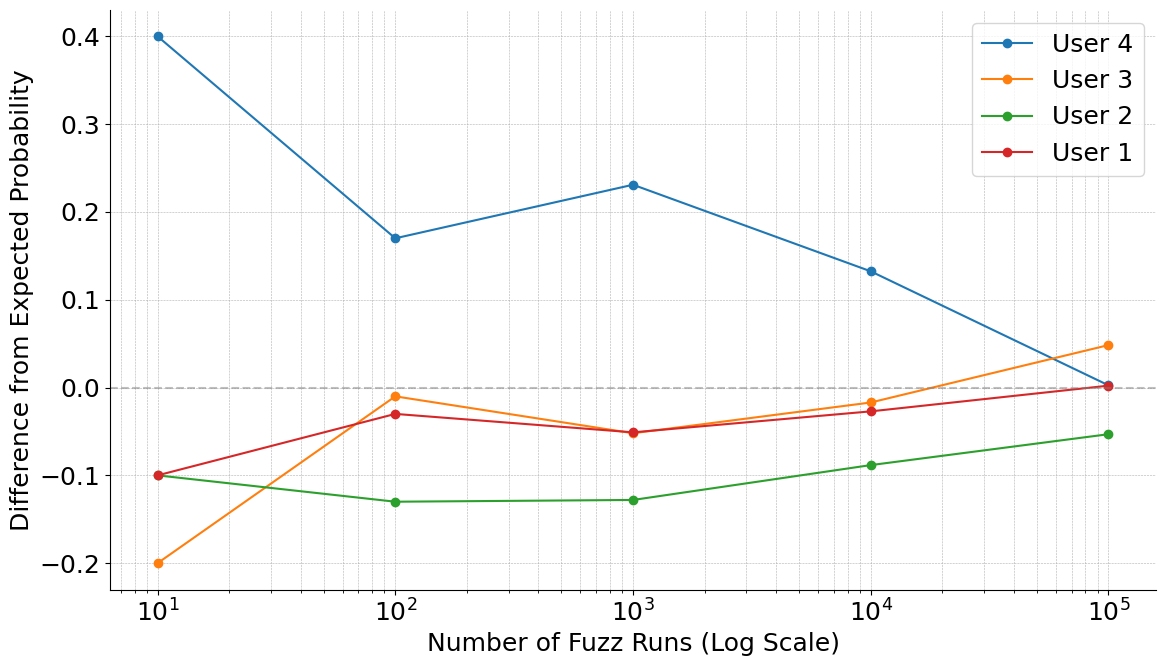

In [15]:
# Calculate the differences between observed and expected probabilities for each user and each test run
differences = []
for obs_probs in observed_probs:
    diff = {user: obs_probs.get(user, 0) - prob for user, prob in expected_probs.items()}
    differences.append(diff)

# Plot the differences
plt.figure(figsize=(12, 7))
for user in expected_probs:
    plt.plot(num_runs, [diff[user] for diff in differences], label=user, marker='o')

# Increase font size
plt.rcParams.update({'font.size': 18})

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # Line at difference of 0
plt.xscale("log")
plt.xlabel("Number of Fuzz Runs (Log Scale)")
plt.ylabel("Difference from Expected Probability")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.4)
# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

file_path = 'charts/raffleFuzzSimpleDiff.png'
plt.savefig(file_path)
plt.show()

<Figure size 640x480 with 0 Axes>

In [57]:
observed_probs

[{'User 4': 0.8, 'User 2': 0.1, 'User 3': 0.1},
 {'User 4': 0.57, 'User 3': 0.29, 'User 1': 0.07, 'User 2': 0.07},
 {'User 4': 0.631, 'User 3': 0.248, 'User 2': 0.072, 'User 1': 0.049},
 {'User 4': 0.5324, 'User 3': 0.283, 'User 2': 0.1117, 'User 1': 0.0729},
 {'User 4': 0.40258, 'User 3': 0.34837, 'User 2': 0.14688, 'User 1': 0.10217}]

In [58]:
expected_probs

{'User 4': 0.4, 'User 3': 0.3, 'User 2': 0.2, 'User 1': 0.1}

The plot shows the difference between the observed and expected winning probabilities for each user as the number of runs increases.

The y-axis represents the difference between the observed probability and the expected probability for each user. A difference of zero (indicated by the dashed horizontal line) implies that the observed probability matches the expected probability.

As we can see:

- As the number of runs increases, the differences tend to converge towards zero. This indicates that the observed probabilities are getting closer to the expected probabilities with more samples.

- Variability in the differences decreases as the number of runs increases, which is consistent with our expectations for a fair system.
This visualisation provides a clearer picture of the system's behaviour and how it approaches the expected outcomes as the number of runs increases.

In [13]:
df10.to_csv('data/raffleFuzzSimple_10.csv', index=False)
df100.to_csv('data/raffleFuzzSimple_100.csv', index=False)
df1000.to_csv('data/raffleFuzzSimple_1000.csv', index=False)
df10000.to_csv('data/raffleFuzzSimple_10000.csv', index=False)
df100000.to_csv('data/raffleFuzzSimple_100000.csv', index=False)

In [12]:
df10

,Winner
0,0x93BDBe2c9f0F5cec59175C51D0a39fAee42A4a6e
1,0x267228fC1E0CdD70e5907fDd47451F0bdAa6186C
2,0x267228fC1E0CdD70e5907fDd47451F0bdAa6186C
3,0x267228fC1E0CdD70e5907fDd47451F0bdAa6186C
4,0x472678022927894035D158D8F3ACCE2b91e13d3E
5,0x267228fC1E0CdD70e5907fDd47451F0bdAa6186C
6,0x267228fC1E0CdD70e5907fDd47451F0bdAa6186C
7,0x267228fC1E0CdD70e5907fDd47451F0bdAa6186C
8,0x267228fC1E0CdD70e5907fDd47451F0bdAa6186C
9,0x267228fC1E0CdD70e5907fDd47451F0bdAa6186C
